# Predicting the Past, United States Validation
## Isotopic Mass Comparison

For this validation, there are 2 notebooks that reflect this work. This notebook (isotopic-mass-validation.ipynb) and total-mass-validation.ipynb 

This notebook includes comparisons between _CYCLUS_ output and UDB data for the United States from 1968 to 2013 for: 
 - Total spent fuel mass for each isotope with decay turned on 

The UDB data is taken from UNF_ST&DARDS Unified Database and the Automatic Document Generator. 

The _CYCLUS_ data was generated by using published data of the commericial reactors that have operated in the United States. The _CYCLUS_ input file and simulation were generated in the original Predicting the Past, United States notebook. This notebook uses the SQL data file produced from the _CYCLUS_ simulation to do further analysis. 

## Details
Decay was turned on by adding 10 storage facilities to the input xml file that each take in consecutive ~ 5 years of spent fuel (with exception to 1st storage facility that takes ~ 10 years and 10th that takes everything after 2014) and outputs the spent fuel at year 2020. 

** Import necessary libraries ** 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import csv
import collections
from collections import defaultdict
import dateutil.parser as date
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import sys
import operator
import re 
import sqlite3 as lite
from matplotlib import cm
from pyne import nucname as nn
from IPython.display import Image, HTML, display
import seaborn as sns 
from colour import Color
import udb_analysis as udb

sys.path.append('../../../scripts/')
import analysis as an

try:
    import cPickle as pickle 
except ImportError: 
    import pickle 

** Run Cyclus simulation **

In [ ]:
# BU 33 GWdt/MTU 
!rm cyclus/united_states_decayon_underestm_33.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_33.xml -o ./cyclus/united_states_decayon_underestm_33.sqlite --warn-limit 0

In [ ]:
# BU 51 GWdt/MTU 
!rm cyclus/united_states_decayon_underestm_51.sqlite
!cyclus -i ./cyclus/input/united_states_underestm_51.xml -o ./cyclus/united_states_decayon_underestm_51.sqlite --warn-limit 0

** Setting up to analyze sqlite file ** 

In [2]:
# Before this step, must download the output sqlite files from the fuel-cycles box. 
# fuel-cycle/cyclus_output/predicting_the_past_validation 
# and put into a directory named cyclus or run the above cells

cursor_51 = an.get_cursor('cyclus/united_states_decayon_underestm_51.sqlite')
cursor_33 = an.get_cursor('cyclus/united_states_decayon_underestm_33.sqlite')

** Get total spent fuel produced after cooling in spent fuel pool until 2020** 

In [3]:
def total_spent_fuel_produced(cur): 
    """ Find timeseries of mass of spent fuel output by reactors 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    
    Returns 
    -------
    timeseries list of spent fuel output by reactors
    """
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
        
        init_yr, init_month, duration, timestep = an.get_timesteps(cur)
        spent_fuel = cur.execute('SELECT time, sum(quantity) FROM transactions '
                                 'INNER JOIN resources '
                                 'ON transactions.resourceid = resources.resourceid '
                                 'WHERE Commodity =:cool_spent_uox' # must specify isotope and pool
                                 ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox}).fetchall()
        spent_fuel_list = an.get_timeseries(spent_fuel,duration,True)
        spent_fuel_total = np.sum(spent_fuel_list)
        total_list.append(spent_fuel_total)
        
    total_cum = np.cumsum(total_list)
    return total_cum 
total_spentfuel_33 = total_spent_fuel_produced(cursor_33)

** Get specific isotope composition from total spent fuel produced after cooling in spent fuel pool until 2020** 

In [4]:
def isotope_total_cum(cur,num,in_dict):
    """ Find total isotopes present in spent fuel output by reactor for each cooling pool and sum cumulatively 
    
    Parameters 
    ----------
    cur: sqlite cursor 
    num: nucid 
    
    Returns 
    -------
    list of isotopes in spent fuel output by reactors added cumulatively for each cooling pool
    """    
    
    coollist = ["cool_spent_uox1","cool_spent_uox2","cool_spent_uox3","cool_spent_uox4","cool_spent_uox5","cool_spent_uox6","cool_spent_uox7","cool_spent_uox8","cool_spent_uox9"]
    isotope_total_list = []
    
    for x in range(0,9):
        cool_spent_uox = coollist[x]
    
        init_yr, init_month, duration, timestep = get_timesteps(cur)
        isotopes = cur.execute('SELECT time, sum(quantity)*massfrac FROM transactions '
                               'INNER JOIN resources '
                               'ON transactions.resourceid = resources.resourceid '
                               'LEFT OUTER JOIN compositions '
                               'ON resources.qualid = compositions.qualid '
                               'WHERE Commodity =:cool_spent_uox AND nucid =:num ' # must specify isotope and pool
                               ' GROUP BY time ',{"cool_spent_uox": cool_spent_uox, "num":num}).fetchall()
        isotope_list = an.get_timeseries(isotopes,duration,True)
        isotope_total = np.sum(isotope_list)
        isotope_total_list.append(isotope_total)
    
    isotope_total_cum = np.cumsum(isotope_total_list)
    name = nn.name(num)
    in_dict[name] = isotope_total_cum
    return

** To create dictionaries of burn up 51 and 33 (this takes a whole day to run) **

In [ ]:
dict_51 = {}
nucnum = [20040000, 882260000, 882280000, 822060000, 822070000, 822080000, 822100000, 902280000, 902290000, 902300000, 902320000, 832090000, 892270000, 912310000, 922320000, 922330000, 922340000, 922350000, 922360000, 922380000, 932370000, 942380000, 942390000, 942400000, 942410000, 942420000, 942440000, 952410000, 952420001, 952430000, 962420000, 962430000, 962440000, 962450000, 962460000, 962470000, 962480000, 962500000, 982490000, 982500000, 982510000, 982520000, 10030000, 60140000, 360810000, 360850000, 380900000, 430990000, 531290000, 551340000, 551350000, 551370000]
for x in range(0,52):
    num = nucnum[x]
    print(x)
    isotope_total_cum(cursor_51,num,dict_51)
    
dict_33 = {}
for x in range(0,52):
    num = nucnum[x]
    print(x)
    isotope_total_cum(cursor_33,num,dict_33)

In [19]:
# To store once created
with open('dict_51.p','wb') as fp:
    pickle.dump(dict_51,fp,protocol=pickle.HIGHEST_PROTOCOL)
with open('dict_33.p','wb') as fp:
    pickle.dump(dict_33,fp,protocol=pickle.HIGHEST_PROTOCOL)

** To avoid running ipynb for whole day, the output of previously ran ipynb are stored **

In [5]:
# To load picked files into this notebook
with open('dict_51.p', 'rb') as fp:
    dict_51 = pickle.load(fp)
with open('dict_33.p', 'rb') as fp:
    dict_33 = pickle.load(fp)

** Run UDB analysis (puts UDB data in a form that is easier analyzed and compared with Cyclus data) ** 

In [6]:
spent_fuel_mass_cum, CURIE_isotope_cum_all, curie_isotope_list = udb.udb_analysis('SNF_nuclide_2020_07_01.dat')

## Analysis of differences between UDB and Cyclus data 

In [7]:
def error_total(cyclus_list,pool,absolute): 
    """ Find relative or absolute error between the total spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    cyclus_list: array of cumulative spent fuel mass
    pool: int, the 9 pools refer to cumulative spent fuel data at these year intervals: 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
    absolute: True if absolute error, False if relative error
    
    Returns 
    -------
    relative errors in percentage of spent fuel mass in 2014 
    OR 
    absolute error in [MTHM]
    """   

    curie_list = spent_fuel_mass_cum.values
    cyclus_2014 = cyclus_list[pool-1] 
    
    curie = [64, 234, 429, 670, 922, 1167, 1417, 1670, -1] # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
    curie_2014 = curie_list[curie[pool-1]]
    
    if absolute: 
        error= (cyclus_2014-curie_2014)
    else: 
        error= ((cyclus_2014-curie_2014)/curie_2014)*100
    return error     

In [10]:
def isotope_error(in_dict,pool,absolute): 
    """ Find relative or absolute error between the total isotopes present in spent fuel output in 2014 for cyclus and udb data 
    
    Parameters 
    ----------
    in_dict = dictionary of isotopes and their corresponding cumilative spent fuel mass 
    pool = int of pool number you want to compare isotopes at 
    absolute: True if absolute error, False if relative error
    
    Returns 
    -------
    relative errors in percentage of the specified isotope in a dictionary 
    OR 
    absolute error in [MTHM] of the specified isotope in a dictionary
    """    
    isotope_names = ['He4', 'Ra226', 'Ra228', 'Pb206', 'Pb207', 'Pb208', 'Pb210', 'Th228', 'Th229', 'Th230', 'Th232', 'Bi209', 'Ac227', 'Pa231', 'U232', 'U233', 'U234', 'U235', 'U236', 'U238', 'Np237', 'Pu238', 'Pu239', 'Pu240', 'Pu241', 'Pu242', 'Pu244', 'Am241', 'Am242M', 'Am243', 'Cm242', 'Cm243', 'Cm244', 'Cm245', 'Cm246', 'Cm247', 'Cm248', 'Cm250', 'Cf249', 'Cf250', 'Cf251', 'Cf252', 'H3', 'C14', 'Kr81', 'Kr85', 'Sr90', 'Tc99', 'I129', 'Cs134', 'Cs135', 'Cs137']
    error_isotope = {}
    for x in range(0,52): 
        cyclus_2014 = in_dict[isotope_names[x]][pool-1]
        curie = [64, 234, 429, 670, 922, 1167, 1417, 1670, -1] # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
        #print(cyclus_2014)
        element_name = isotope_names[x]
        element_name = element_name.lower()
        match = re.match(r"([a-z]+)([0-9]+)", element_name, re.I)
        if match:
            items = match.groups()
            #print(items)
        num_name = items[0]+ "-" + items[1]
        #print(num_name)
        if any (num_name in s for s in curie_isotope_list):
            if num_name == 'am-242':
                curie_list = CURIE_isotope_cum_all.loc[:,('total_mass_g', 'am-242m')]
                curie_list = curie_list.to_frame()
                curie_list = curie_list.multiply(0.000001)
                curie_list = curie_list.values

                curie_2014 = curie_list[curie[pool-1]]
                if absolute: 
                    error = (cyclus_2014-curie_2014)
                else: 
                    error = ((cyclus_2014-curie_2014)/curie_2014)*100
                error_isotope[element_name] = error  
            else: 
                curie_list = CURIE_isotope_cum_all.loc[:,('total_mass_g', num_name)]
                curie_list = curie_list.to_frame()
                curie_list = curie_list.multiply(0.000001)
                curie_list = curie_list.values

                curie_2014 = curie_list[curie[pool-1]]
                if absolute: 
                    error = (cyclus_2014-curie_2014)
                else: 
                    error = ((cyclus_2014-curie_2014)/curie_2014)*100
                error_isotope[element_name] = error 
        #else: 
            #print(num_name,'does not exist in curie data')
    return error_isotope  

In [11]:
# To check what the total absolute error (between Cyclus and UDB data) is for each cumulative year pool
abs_error_dict = {}
for x in range(0,9):
    year = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    pool = x+1
    y = error_total(total_spentfuel_33,pool,True)
    abs_error_dict[year[x]] = y

In [12]:
def isotope_error_list(in_dict): 
    """ Finds absolute error between the total isotopes present in spent fuel output for 9 time steps for cyclus and udb data 
    # 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
    
    Parameters 
    ----------
    in_dict = dictionary of isotopes and their corresponding cumilative spent fuel mass  
    
    Returns 
    -------
    Dictionary of of errors of each specified isotope in the 9 time steps 
    """  
    dict_isotopes =  defaultdict(list)
    for x in range(0,9): 
        isotope_dict = isotope_error(in_dict,x,True)
        for key in isotope_dict:
            specific_isotope_dict = isotope_dict[key]
            #print(specific_isotope_dict)
            dict_isotopes[key].append(specific_isotope_dict)
    return dict_isotopes

In [13]:
dict_51_isotopes_list = isotope_error_list(dict_51)
dict_33_isotopes_list = isotope_error_list(dict_33)

In [14]:
def sort_error(in_list_sort,in_list_copy):
    """ Sort in_list_copy based on the first column in_list_sort 
    
    Parameters 
    ----------
    in_list_sort = list with 2 columns. First is isotope names, second is their relative error in percentage 
    in_list_copy = list with 2 columns. First is isotope names, second is their relative error in percentage 
    
    Returns 
    -------
    in_list_copy with its list rearranged to follow the first column in in_list_sort  
    
    """
    sorted_sort = sorted(in_list_sort.items(),key=operator.itemgetter(1))
    sorted_copy = sorted(in_list_copy.items(),key=operator.itemgetter(1))
    values_copy_sorted = []
    length1 = len(sorted_sort)
    length2 = len(sorted_copy)
    for x in range(0,length1):
        keys_sort = sorted_sort[x][0]
        for y in range(0,length2): 
            keys_copy = sorted_copy[y][0]
            if keys_sort == keys_copy: 
                values_copy_sorted.append(sorted_copy[y])
                break
    return sorted_sort,values_copy_sorted

** Real world Burn up information ** 

In [15]:
# dict of spent fuel information 
# taken from: https://www.eia.gov/nuclear/spent_fuel/ussnftab3.php
dict_spentfuel_eia =  defaultdict(list)
dict_average_burn_up =  defaultdict(list)
# 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014
dict_spentfuel_eia['1975'] = [164.9,299.4,17.2,17.4]
dict_spentfuel_eia['1980'] = [564.9,617.6,22.3,29.8]
dict_spentfuel_eia['1985'] = [542.6,859.7,23.6,32.0]
dict_spentfuel_eia['1990'] = [681.1,1480.8,25.4,34.6]
dict_spentfuel_eia['1995'] = [780.6,1627.3,32.8,40.9]
dict_spentfuel_eia['2000'] = [800.4,1368.0,38.3,44.9]
dict_spentfuel_eia['2005'] = [707.0,1626.0,42.8,46.6]
dict_spentfuel_eia['2010'] = [820.9,1250.9,44.3,46.8]
dict_spentfuel_eia['2014'] = [575.5,665.8,44.1,45.4]
for key in dict_spentfuel_eia: 
    dict_average_burn_up[key] = (dict_spentfuel_eia[key][0]*dict_spentfuel_eia[key][2]+dict_spentfuel_eia[key][1]*dict_spentfuel_eia[key][3])/(dict_spentfuel_eia[key][0]+dict_spentfuel_eia[key][1])

In [16]:
# cumulative burn up was calculated in cum_ave_burnup.xlsx
# The results corresponding to relevant years is included here
dict_cum_burn_up =  defaultdict(list)
dict_cum_burn_up['1975'] = 16.95151515
dict_cum_burn_up['1980'] = 22.33243684
dict_cum_burn_up['1985'] = 25.3447386
dict_cum_burn_up['1990'] = 27.15992636
dict_cum_burn_up['1995'] = 30.15556123
dict_cum_burn_up['2000'] = 32.7058552
dict_cum_burn_up['2005'] = 35.15625665
dict_cum_burn_up['2010'] = 37.00594291
dict_cum_burn_up['2014'] = 37.7196081

** Plot of average cumulative burn up**

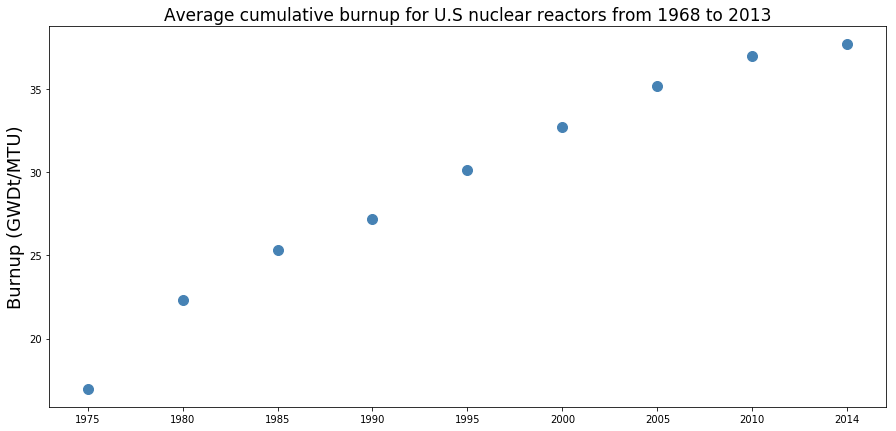

In [19]:
x = (dict_cum_burn_up.keys())
y_pos = np.arange(len(x))
fig, ax = plt.subplots(figsize=(15,7))
ax.scatter(y_pos, dict_cum_burn_up.values(), color='steelblue', s = 100)
box = ax.get_position()
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x)
ax.set_ylabel('Burnup (GWDt/MTU)', fontsize=18)
ax.set_title('Average cumulative burnup for U.S nuclear reactors from 1968 to 2013', fontsize=17)
plt.savefig('figures/burn_up_real.png', bbox_inches="tight")

** Plot of difference between average cumulative burn up in real world and Cyclus simulation ** 

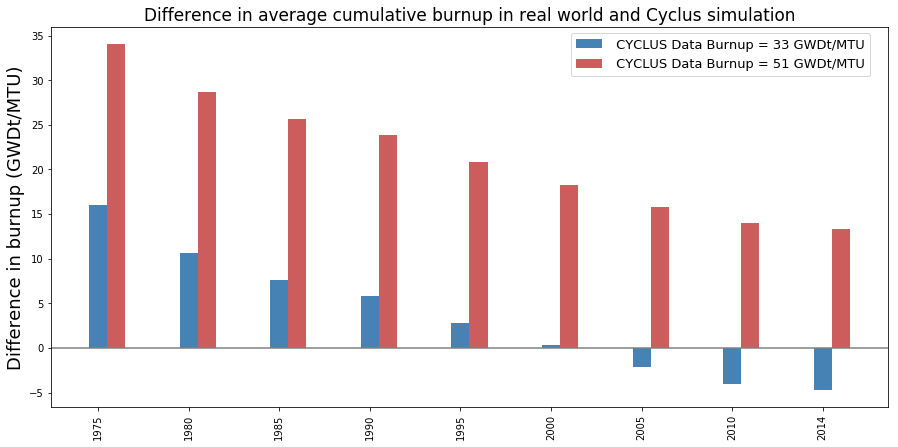

In [34]:
dict_average_burn_up_diff_33 =  defaultdict(list)
dict_average_burn_up_diff_51 =  defaultdict(list)
for key in dict_cum_burn_up: 
    dict_average_burn_up_diff_33[key] = 33-(dict_cum_burn_up[key])
    dict_average_burn_up_diff_51[key] = 51-(dict_cum_burn_up[key])
x = (dict_average_burn_up_diff_33.keys())
y_pos = np.arange(len(x))
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(y_pos, dict_average_burn_up_diff_33.values(), width = 0.2, color='steelblue',label=' CYCLUS Data Burnup = 33 GWDt/MTU' )
ax.bar(y_pos+0.2, dict_average_burn_up_diff_51.values(), width = 0.2, color='indianred',label=' CYCLUS Data Burnup = 51 GWDt/MTU' )
box = ax.get_position()
plt.axhline(y=0,color='grey')
ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
handles, labels = ax.get_legend_handles_labels()
plt.xticks(y_pos,x,rotation=90)
ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.8,1),fancybox=True)
ax.set_ylabel('Difference in burnup (GWDt/MTU)', fontsize=18)
ax.set_title('Difference in average cumulative burnup in real world and Cyclus simulation', fontsize=17)
plt.savefig('figures/burn_up_difference.png', bbox_inches="tight")

## Plotting of absolute and relative differences between UDB and Cyclus data

In [25]:
def plot_isotope_error_list(isotope):
    """ Plots absolute error between spent fuel mass from UDB data and Cyclus data for the specified isotope
    
    Parameters 
    ----------
    isotope: string of isotope name 
    
    Returns 
    -------
    returns a plot of absolute error between spent fuel mass from UDB data and Cyclus data for specified isotope
    
    """
    
    dates = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    fig, ax = plt.subplots(figsize=(15,7))
    ax.scatter(dates,dict_51_isotopes_list[isotope],color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWDt/MTU', marker = "o", s = 50)
    ax.scatter(dates,dict_33_isotopes_list[isotope],color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWDt/MTU', marker = "o", s = 50)
    box = ax.get_position()
    ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
    ax.set_ylabel('Absolute error (MTHM)', fontsize=18)
    ax.set_title('Absolute Error between spent fuel mass from UDB data and CYCLUS data for %s' % isotope, fontsize=17)
    plt.savefig('figures/absolute_error_%s.png' % isotope, bbox_inches="tight")
    return 

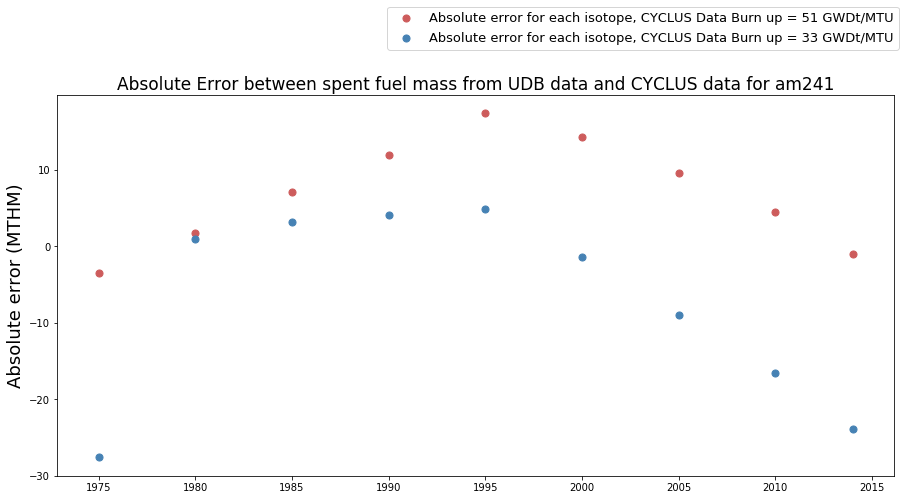

In [26]:
plot_isotope_error_list('am241')
#plot_isotope_error_list('pu240')
#plot_isotope_error_list('pu239')

** Plot of absolute error for each isotope ** 

In [47]:
def plot_absolute_error(pool,y_bottom_limit,y_top_limit,zoomout): 
    abs_error_51 = isotope_error(dict_51,pool,True)
    abs_error_33 = isotope_error(dict_33,pool,True)
    sorted_abs_error_51, sorted_abs_error_33 = sort_error(abs_error_51,abs_error_33)
    
    year = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    this_year = year[pool-1]
    
    x = list(list(zip(*sorted_abs_error_51))[0])
    y1 = list(list(zip(*sorted_abs_error_51))[1])
    y2 = list(list(zip(*sorted_abs_error_33))[1])
    y_pos = np.arange(len(x))

    fig, ax = plt.subplots(figsize=(15,7))
    plt.axhline(y=0,color='grey')
    ax.scatter(y_pos,y1,color = 'indianred', label='Absolute error for each isotope, CYCLUS Data Burn up = 51 GWDt/MTU', marker = "o", s = 50)
    ax.scatter(y_pos,y2,color = 'steelblue', label='Absolute error for each isotope, CYCLUS Data Burn up = 33 GWDt/MTU', marker = "o", s = 50)
    box = ax.get_position()
    ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
    handles, labels = ax.get_legend_handles_labels()
    plt.xticks(y_pos,x,rotation=90,fontsize=13)
    ax.set_ylim(bottom=y_bottom_limit,top=y_top_limit)
    ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
    ax.set_ylabel('Absolute Difference (MTHM)', fontsize=18)
    ax.set_title('Absolute difference between spent fuel mass from UDB data and CYCLUS data for each isotope in %i' % this_year , fontsize=17)
    if zoomout: 
        plt.savefig('figures/absolute_diff_zoomout_%i.png' % this_year , bbox_inches="tight")
    else: 
        plt.savefig('figures/absolute_diff_%i.png' % this_year , bbox_inches="tight")
    return

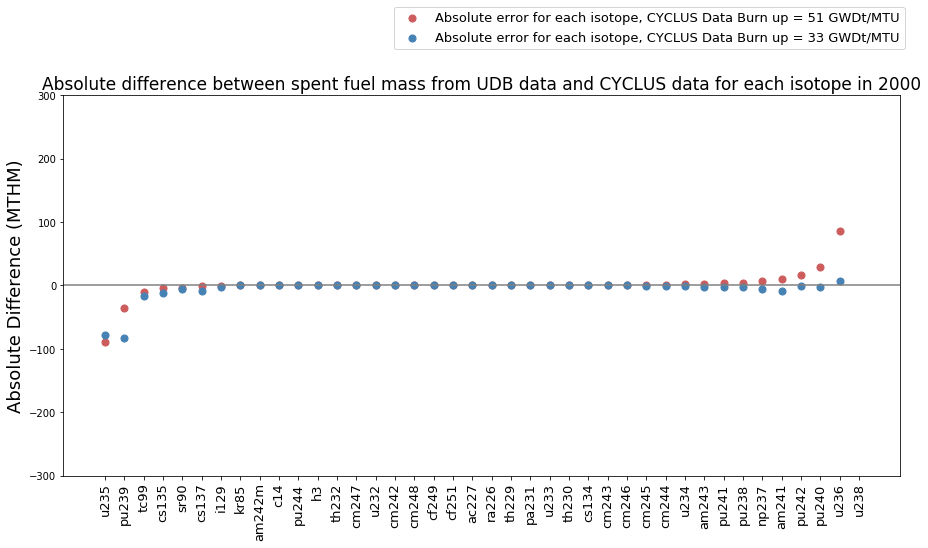

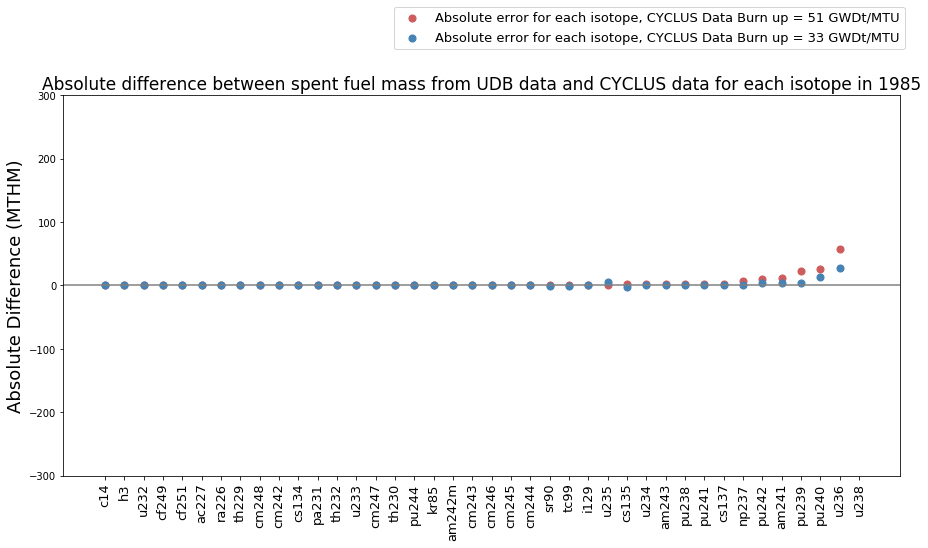

In [48]:
#plot_absolute_error(9,-10000,10000,True)
#plot_absolute_error(9,-100,100,False)

#plot_absolute_error(5,-100,100,False)

#plot_absolute_error(6,-10000,10000,True)
plot_absolute_error(6,-300,300,False)

#plot_absolute_error(7,-200,200,False)

plot_absolute_error(3,-300,300,False)

** Plot of absolute error for each isotope for all pools for one burn up** 

In [39]:
def plot_absolute_diff_all(burnup,in_dict_51,in_dict_33,y_bottom_limit,y_top_limit,zoomout): 
    
    year = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    dict_of_all_33 = {}
    dict_of_all_51 = {}
    abs_error_2014_51 = isotope_error(in_dict_51,9,True)
    for x in range(0,9): 
        pool = x+1
        abs_error_33 = isotope_error(in_dict_33,pool,True)
        abs_error_51 = isotope_error(in_dict_51,pool,True)
        sorted_abs_error_2014_33, sorted_abs_error_33 = sort_error(abs_error_2014_51,abs_error_33)
        sorted_abs_error_2014_51, sorted_abs_error_51 = sort_error(abs_error_2014_51,abs_error_51)
        dict_of_all_33[year[x]] = sorted_abs_error_33
        dict_of_all_51[year[x]] = sorted_abs_error_51
    dict_of_all_51[year[8]] = sorted_abs_error_2014_51
    
    red = Color("red")
    colors = list(red.range_to("Blue",10))
    
    fig, ax = plt.subplots(figsize=(15,7))
    num = 0 
    
    if burnup ==33: 
        for key in dict_of_all_33:
            num = num + 1 
            #print(key)
            data_dict = dict_of_all_33[key]
            x = list(list(zip(*data_dict))[0])
            #print(x)
            y_pos = np.arange(len(x))
            y = list(list(zip(*data_dict))[1])
            #print(y)
            ax.scatter(y_pos,y,label = '%i' % key, color = colors[num-1].hex_l, s = 50)

        plt.axhline(y=0,color='grey')
        box = ax.get_position()
        ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
        handles, labels = ax.get_legend_handles_labels()
        plt.xticks(y_pos,x,rotation=90,fontsize=13)
        ax.set_ylim(bottom=y_bottom_limit,top=y_top_limit)
        ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(1.1,0.9),fancybox=True)
        ax.set_ylabel('Absolute Difference (MTHM)', fontsize=18)
        ax.set_title('Absolute difference between spent fuel mass from UDB data and CYCLUS data for each isotope for 33 GWDt/MTU' , fontsize=17)
        if zoomout: 
            plt.savefig('figures/absolute_diff_all_33_zoomout.png' , bbox_inches="tight")
        else: 
            plt.savefig('figures/absolute_diff_all_33.png' , bbox_inches="tight")
    else:
        for key in dict_of_all_51:
            num = num + 1 
            #print(key)
            data_dict = dict_of_all_51[key]
            x = list(list(zip(*data_dict))[0])
            #print(x)
            y_pos = np.arange(len(x))
            y = list(list(zip(*data_dict))[1])
            #print(y)
            ax.scatter(y_pos,y,label = '%i' % key, color = colors[num-1].hex_l, s= 50)

        plt.axhline(y=0,color='grey')
        box = ax.get_position()
        ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
        handles, labels = ax.get_legend_handles_labels()
        plt.xticks(y_pos,x,rotation=90,fontsize=13)
        ax.set_ylim(bottom=y_bottom_limit,top=y_top_limit)
        ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(1.1,0.9),fancybox=True)
        ax.set_ylabel('Absolute Difference (MTHM)', fontsize=18)
        ax.set_title('Absolute difference between spent fuel mass from UDB data and CYCLUS data for each isotope for 51 GWDt/MTU' , fontsize=17)
        if zoomout: 
            plt.savefig('figures/absolute_diff_all_51_zoomout.png' , bbox_inches="tight")
        else: 
            plt.savefig('figures/absolute_diff_all_51.png' , bbox_inches="tight")    
    return 

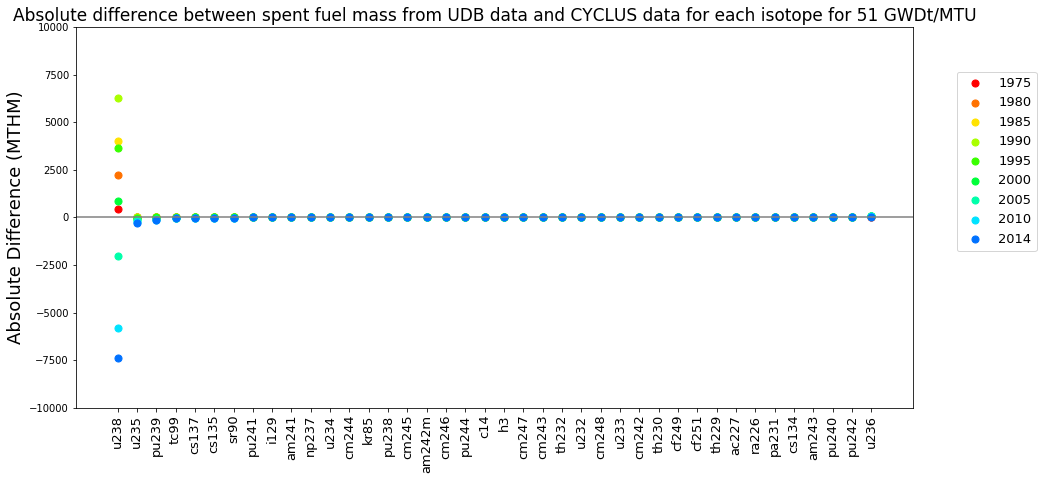

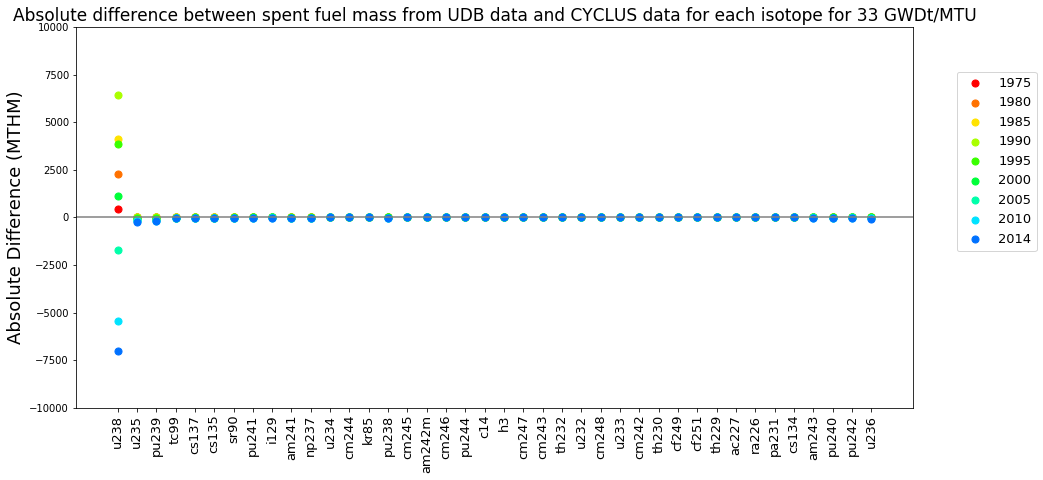

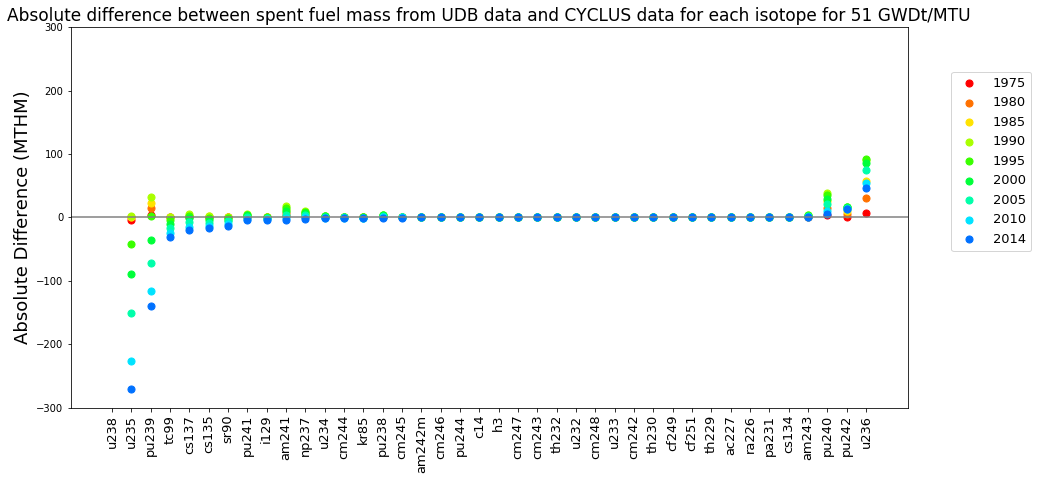

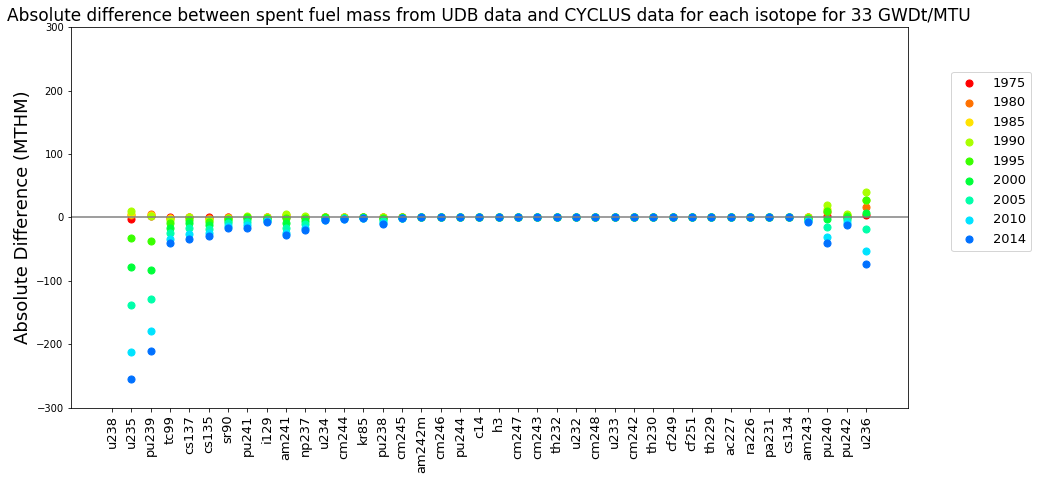

In [40]:
plot_absolute_diff_all(51,dict_51,dict_33,-10000,10000,True)
plot_absolute_diff_all(33,dict_51,dict_33,-10000,10000,True)
plot_absolute_diff_all(51,dict_51,dict_33,-300,300,False)
plot_absolute_diff_all(33,dict_51,dict_33,-300,300,False)

** Plot of relative error for each isotope at a specific year  **

In [41]:
def plot_relative_error(pool): 
    rel_error_51 = isotope_error(dict_51,pool,False)
    rel_error_33 = isotope_error(dict_33,pool,False)
    sorted_rel_error_51, sorted_rel_error_33 = sort_error(rel_error_51,rel_error_33)
    
    year = [1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2014]
    this_year = year[pool-1]
    
    x = list(list(zip(*sorted_rel_error_51))[0])
    y1 = list(list(zip(*sorted_rel_error_51))[1])
    y2 = list(list(zip(*sorted_rel_error_33))[1])
    y_pos = np.arange(len(x))
    
    total_relative_error = error_total(total_spentfuel_33,pool,False)
    fig, ax = plt.subplots(figsize=(15,7))
    plt.axhline(y=total_relative_error,color='grey',label='Relative error for total spent fuel mass')
    ax.scatter(y_pos,y1,color = 'indianred', label='Relative error for each isotope, CYCLUS Data Burn up = 51 GWDt/MTU', marker = "o")
    ax.scatter(y_pos,y2,color = 'steelblue', label='Relative error for each isotope, CYCLUS Data Burn up = 33 GWDt/MTU', marker = "o")
    box = ax.get_position()
    ax.set_position([box.x0,box.y0 + box.height,box.width,box.height*1])
    handles, labels = ax.get_legend_handles_labels()
    plt.xticks(y_pos,x,rotation=90,fontsize = 13)
    ax.set_ylim(bottom=-100,top=100)
    ax.legend(handles, labels, fontsize=13,loc='upper center',bbox_to_anchor=(0.7,1.25),fancybox=True)
    ax.set_ylabel('Relative Difference (%)', fontsize=18)
    ax.set_title('Relative difference between spent fuel mass from UDB data and CYCLUS data for each isotope in %i' % this_year , fontsize=17)
    plt.savefig('figures/relative_diff_%i.png' % this_year , bbox_inches="tight")
    return

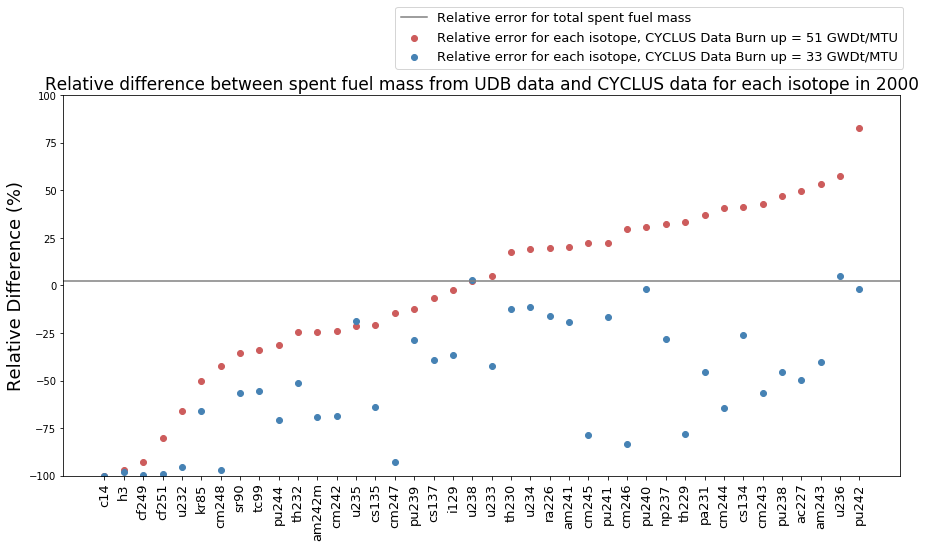

In [49]:
plot_relative_error(6)